# Parcel Geocoding Scipt

Matches parcels, based on stripped Parid, to parcels in the Fulton County geocoded tax parcels dataset. Spatially joins these parcels with the borders of Atlanta's neighborhoods, giving each parcel a labeled neighborhood column.

By default, uses shapefiles from:
- Fulton County GIS portal for tax parcels (fulton_parcels_path)
- Atlanta GIS portal for Atlanta parcels; needed as Fulton does not cover all of Atlanta (atl_parcels_path)
- ARC for official Atlanta neighborhoods (boundary_path)

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib as plt

### Read in shapefiles

In [2]:
####################
# SET SHAPEFILE VARS
####################
fulton_parcels_path = r'C:\Users\nicho\Documents\research\FCS\data\shapefiles\fulton_tax_parcels\Tax_Parcels.shp'
atl_parcels_path = r'C:\Users\nicho\Documents\research\FCS\data\shapefiles\atl_tax_parcels\Tax_Parcel_2021.shp'
boundary_path = r'C:\Users\nicho\Documents\research\FCS\data\shapefiles\atl_neighborhoods\Official_Neighborhoods.shp'

In [3]:
fulton_parcels = gpd.read_file(fulton_parcels_path)
atl_parcels = gpd.read_file(atl_parcels_path)
boundary = gpd.read_file(boundary_path)

In [4]:
fulton_parcels = fulton_parcels[['ParcelID', 'Address', 'geometry']] \
    .rename(columns={'ParcelID': 'parid_geo', 'Address': 'address_geo'})
atl_parcels = atl_parcels[['PARCELID', 'SITEADDRES', 'geometry']] \
    .rename(columns={'PARCELID': 'parid_geo', 'SITEADDRES': 'address_geo'})

Concat Fulton and Atlanta parcels to get the full universe. Drop rows with duplicate 'parid' to remove the overlap between the datasets.

In [5]:
parcels = pd.concat([fulton_parcels, atl_parcels])
init_len = len(parcels.index)
parcels = parcels.drop_duplicates(subset=['parid_geo'])
print('Count dropped: ', init_len - len(parcels.index))
print('Total parcels in Fulton + Atlanta: ', len(parcels.index))

Count dropped:  153508
Total parcels in Fulton + Atlanta:  381903


In [6]:
boundary = boundary[['NAME', 'OLDNAME', 'NPU', 'geometry']]
boundary = boundary.rename(columns={'NAME': 'neighborhood', 'OLDNAME': 'old_nbhr_name', 'NPU': 'npu'})

Create parid_strip column

In [7]:
parcels['parid_strip'] = parcels['parid_geo'].str.replace(' ', '')

Plot

<Axes: >

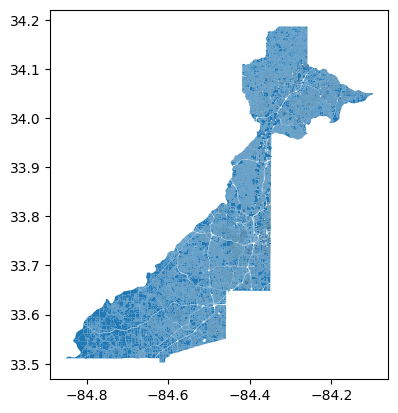

In [8]:
fulton_parcels.plot()

<Axes: >

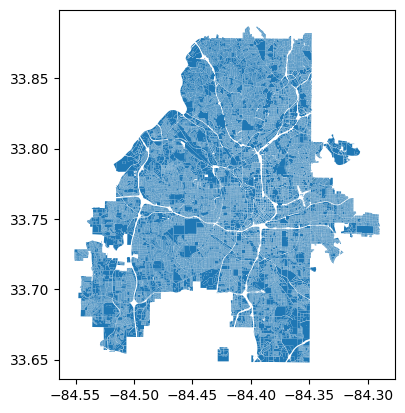

In [9]:
atl_parcels.plot()

<Axes: >

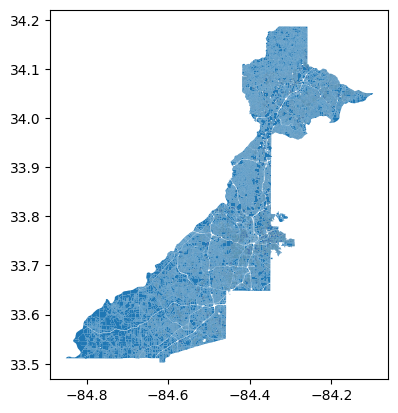

In [10]:
parcels.plot()

<Axes: >

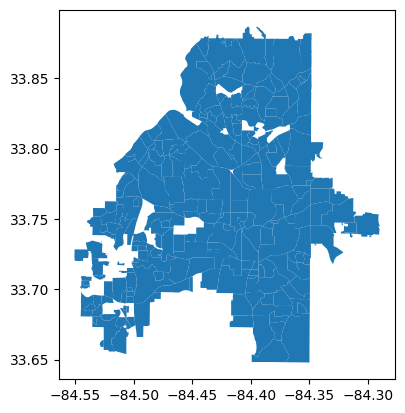

In [11]:
boundary.plot()

### Match target parcels to their shapefile geometry

In [12]:
#########################
# SET DATA TO BE GEOCODED
#########################
to_geocode_path = r'C:\Users\nicho\Documents\research\FCS\output\merged\sales_parcel_left.csv'

In [13]:
to_geocode = pd.read_csv(to_geocode_path)

C:\Users\nicho\AppData\Local\Temp\ipykernel_2512\1031986283.py:1: DtypeWarning: Columns (18,25,29,37,41,44,54) have mixed types. Specify dtype option on import or set low_memory=False.
  to_geocode = pd.read_csv(to_geocode_path)


Match parcels from merged sale-parcel data to the Fulton + Atlanta geocoded data.
Fulton geocoded parcels alone could not match 10.5K. Fulton + Atlanta could not match 9K parcels. Therefore, we chose to include additional Atlanta parcel data (outside of Fulton) even though our sales data should be Fulton only.

In [14]:
geocoded = parcels.merge(to_geocode, how='inner', on='parid_strip')
print("Could not match {} parcels".format(len(to_geocode.index) - len(geocoded.index)))

Could not match 8940 parcels


In [15]:
type(geocoded)

geopandas.geodataframe.GeoDataFrame

No need to convert to a GeoDataFrame if a GDF is the left df for the merge; the resultant df will also be a GDF.

### Spatially join the centroid of each parcel to its associated boundary (neighborhood)

Create a centroid column within the new geocoded (parcel) data and set it as the active geometry. First set CRS equal to a flat projection to find centroid, then re-project onto the standard coordinate system.

In [16]:
geocoded['geometry_pt'] = geocoded.to_crs('+proj=cea').centroid.to_crs("EPSG:4326")
geocoded = geocoded.set_geometry('geometry_pt')

Complete the spatial join, ensuring the CRS is the same.

In [17]:
geocoded_neighborhoods = geocoded.sjoin(boundary.to_crs(geocoded.crs), how='inner')

Plots

<Axes: >

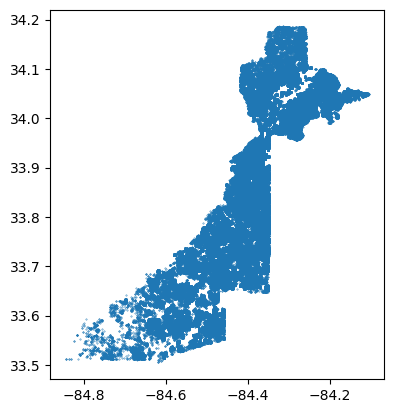

In [18]:
geocoded.plot(markersize=.1)

<Axes: >

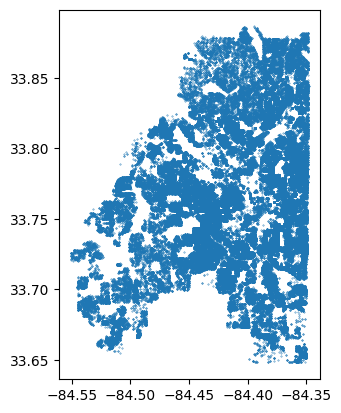

In [19]:
geocoded_neighborhoods.plot(markersize=.1)

### Overlay plot and output

<Axes: >

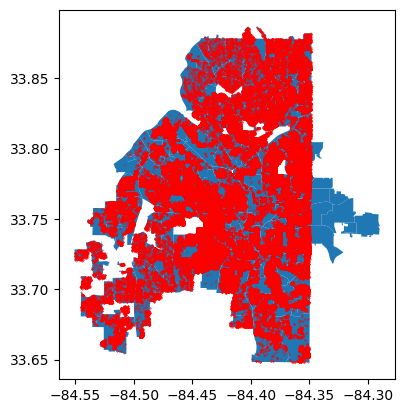

In [20]:
fig, ax = plt.pyplot.subplots()
boundary.plot(ax=ax)
geocoded_neighborhoods.plot(ax=ax, color="red", alpha=0.7, markersize=.1)

Save to CSV. Cannot save to shapefile due to categorical variables. If shapefile is desired, read the CSV and then convert.

In [27]:
geocoded_df = pd.DataFrame(geocoded)
geocoded_df.reset_index().to_csv('../output/geocoded/csv/all_sales_geo.csv')

In [28]:
geocoded_neighborhoods = pd.DataFrame(geocoded_neighborhoods)
geocoded_neighborhoods.reset_index().to_csv('../output/geocoded/csv/atl_sales_neighborhoods.csv')